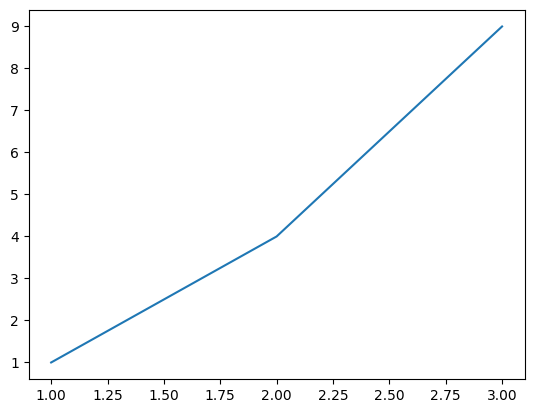

In [22]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()

In [23]:
import pytz
from datetime import datetime
from gym_mtsim import MtEnv, MtSimulator, Timeframe
from stable_baselines3 import A2C
import pandas as pd
import numpy as np

In [24]:
train_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

train_sim.download_data(
    symbols=['BITCOIN'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    time_range=(
        datetime(2021, 6, 30, tzinfo=pytz.UTC),
        datetime(2023, 6, 30, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.D1
)

valid_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

valid_sim.download_data(
    symbols=['BITCOIN'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    time_range=(
        datetime(2023, 1, 7, tzinfo=pytz.UTC),
        datetime(2023, 12, 31, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.D1
)

In [25]:
train_env = MtEnv(
    original_simulator=train_sim,
    trading_symbols=['BITCOIN'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    window_size=30,
    multiprocessing_processes=2
)

valid_env = MtEnv(
    original_simulator=valid_sim,
    trading_symbols=['BITCOIN'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    window_size=30,
    multiprocessing_processes=2
)

In [26]:
train_prices = train_env.get_prices()
valid_prices = valid_env.get_prices()

In [27]:
# just take the same values like in prices but loop over the symbold and concatinate the ndarray on axis 1
train_features = np.concatenate([train_prices[symbol] for symbol in train_prices], axis=1)
valid_features = np.concatenate([valid_prices[symbol] for symbol in valid_prices], axis=1)

In [28]:
train_env.add_signal_features(train_features)
valid_env.add_signal_features(valid_features)

train_env.build_spaces()
valid_env.build_spaces()

In [29]:
print("train_env information:")

for symbol in train_env.prices:
    print(f"> prices[{symbol}].shape:", train_env.prices[symbol].shape)

print("> signal_features.shape:", train_env.signal_features.shape)
print("> features_shape:", train_env.features_shape)

train_env information:
> prices[BITCOIN].shape: (723, 5)
> signal_features.shape: (723, 5)
> features_shape: (30, 5)


In [30]:
print("valid_env information:")

for symbol in valid_env.prices:
    print(f"> prices[{symbol}].shape:", valid_env.prices[symbol].shape)

print("> signal_features.shape:", valid_env.signal_features.shape)
print("> features_shape:", valid_env.features_shape)

valid_env information:
> prices[BITCOIN].shape: (359, 5)
> signal_features.shape: (359, 5)
> features_shape: (30, 5)


action: [-43.59839653] reward: -5000.0 done: True
Final Balance: 0.0


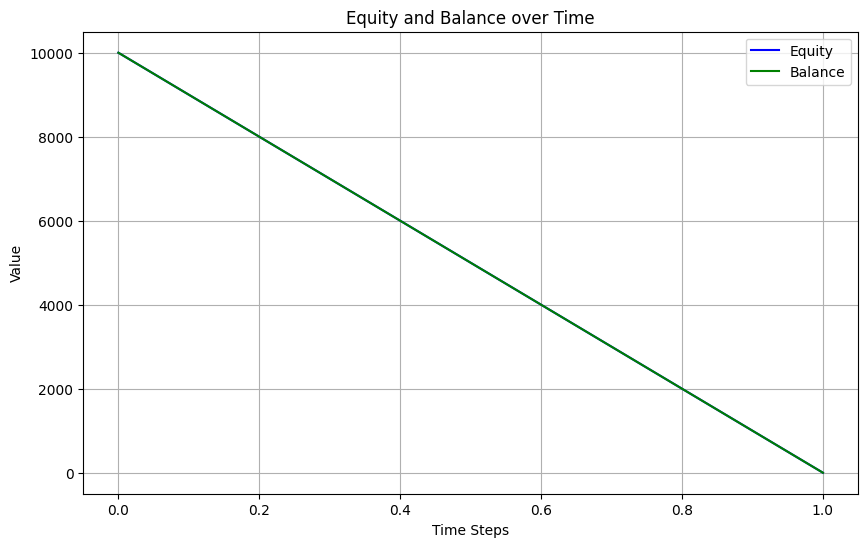

In [31]:
observation = train_env.reset()

while True:
    action = train_env.action_space.sample()
    observation, reward, done, _, info = train_env.step(action)
    print("action:", action, "reward:", reward, "done:", done)


    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break

In [32]:
model = A2C('MultiInputPolicy', train_env, verbose=1)
observation = train_env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [33]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [34]:
check_env(train_env)

C:\Users\stefa\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation features has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
C:\Users\stefa\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
C:\Users\stefa\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\env_checker.py:464: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 83        |
|    ep_rew_mean        | -9.8e+03  |
| time/                 |           |
|    fps                | 134       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.41     |
|    explained_variance | -1.67e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.57e+03 |
|    std                | 0.992     |
|    value_loss         | 2.02e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 286       |
|    ep_rew_mean        | -1.37e+04 |
| time/                 |           |
|    fps                | 108       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_t

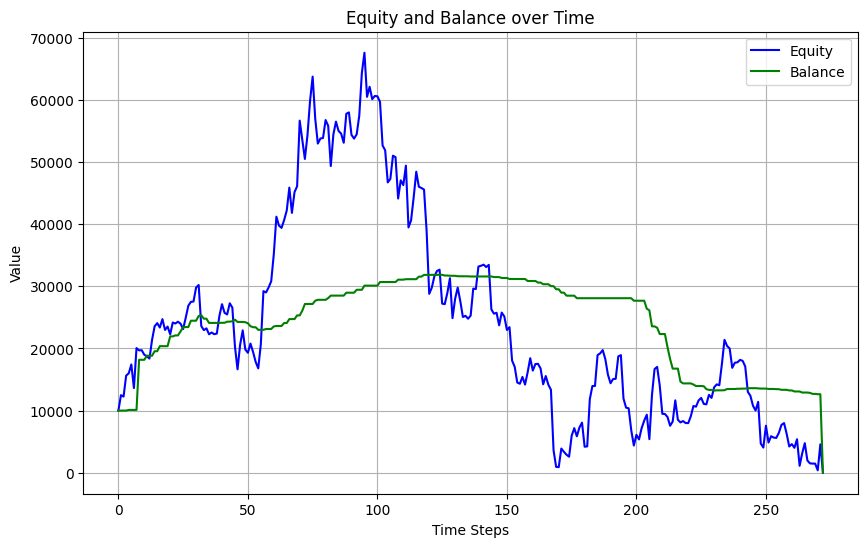

In [35]:
model.learn(total_timesteps=1000)
import time
train_vec_env = model.get_env()
observation = train_vec_env.reset()

while True:
    action, _states = model.predict(observation, deterministic=True)
    action = action.flatten()
    observation, reward, done, _, info = train_env.step(action)

    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Final Balance: 41224.016617910354


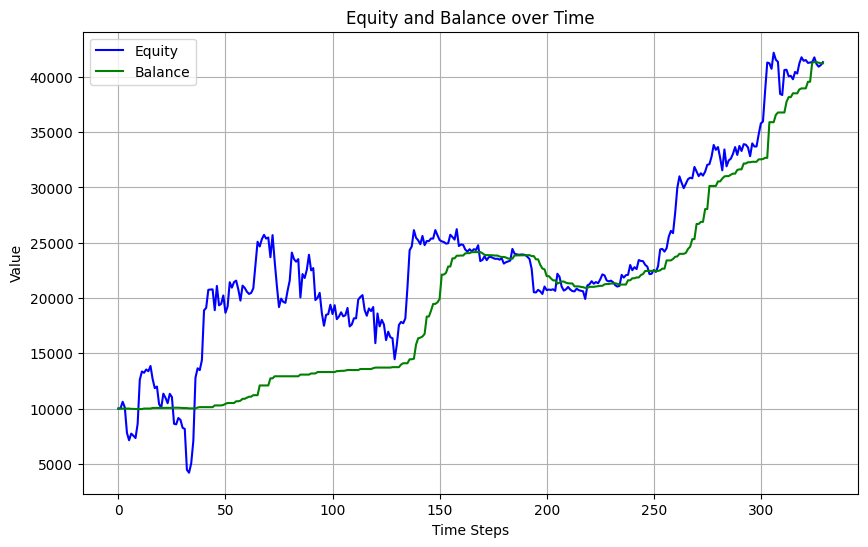

In [36]:
valid_vec_env = A2C('MultiInputPolicy', valid_env, verbose=1).get_env()

observation = valid_vec_env.reset()
while True:
    action, _states = model.predict(observation, deterministic=True)
    action = action.flatten()
    observation, reward, done, _, info = valid_env.step(action)

    if done:
        print("Final Balance:", info['balance'][-1])
        valid_env.render(mode='simple_figure')
        break

In [37]:
from IPython.display import clear_output


episodes = 1000
timesteps = valid_env.signal_features.shape[0]
valid_balance = []


for episode in range(episodes):
    # delete the cell output
    clear_output(wait=True)
    
    model.learn(total_timesteps=timesteps)
    
    observation = train_vec_env.reset()
    while True:
        action, _states = model.predict(observation, deterministic=True)
        action = action.flatten()
        observation, reward, done, _, info = train_env.step(action)

        if done:
            print("Final Balance train_env:", info['balance'][-1])
            train_env.render(mode='simple_figure')
            break
            
    observation = valid_vec_env.reset()
    while True:
        action, _states = model.predict(observation, deterministic=True)
        action = action.flatten()
        observation, reward, done, _, info = valid_env.step(action)

        if done:
            print("Final Balance valid_env:", info['balance'][-1])
            valid_balance.append(info['balance'][-1])
            valid_env.render(mode='simple_figure')
            break
            
    # save the model if it is the best so far
    if valid_balance[-1] == max(valid_balance):
        model.save('best_model')

model = A2C.load('best_model')